In [ ]:
from secrets import AZURE_KEY

In [1]:
from fastai.vision.all import *

In [2]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', AZURE_KEY)

In [3]:
import requests

def search_images_bing(key, term, min_size=128, max_images=150):
    params = dict(q=term, count=max_images, min_height=min_size, min_width=min_size)
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers={"Ocp-Apim-Subscription-Key":key}, params=params)
    response.raise_for_status()
    return L(response.json()['value'])

In [6]:
results = search_images_bing(key, 'fried chicken')

In [11]:
image_urls = results.attrgot('contentUrl')

In [17]:
path = Path('chicken_dogs')

In [21]:
classes = ['fried chicken', 'labradoodle']

In [22]:
if not path.exists():
    path.mkdir()
    for c in classes:
        dest = (path/c)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, c)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [25]:
fns = get_image_files(path)
fns

(#274) [Path('chicken_dogs/labradoodle/00000047.jpg'),Path('chicken_dogs/labradoodle/00000055.jpg'),Path('chicken_dogs/labradoodle/00000063.jpeg'),Path('chicken_dogs/labradoodle/00000014.JPG'),Path('chicken_dogs/labradoodle/00000139.jpeg'),Path('chicken_dogs/labradoodle/00000057.JPG'),Path('chicken_dogs/labradoodle/00000036.jpg'),Path('chicken_dogs/labradoodle/00000097.jpg'),Path('chicken_dogs/labradoodle/00000148.jpg'),Path('chicken_dogs/labradoodle/00000110.jpg')...]

In [28]:
failed = verify_images(fns)
failed

(#1) [Path('chicken_dogs/fried chicken/00000082.jpg')]

In [ ]:
failed.map(Path.unlink)

In [32]:
chicken_dogs = DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items=get_image_files,
                         splitter=RandomSplitter(valid_pct=0.2, seed=42),
                         get_y=parent_label,
                         item_tfms=Resize(128))

In [33]:
dls = chicken_dogs.dataloaders(path)

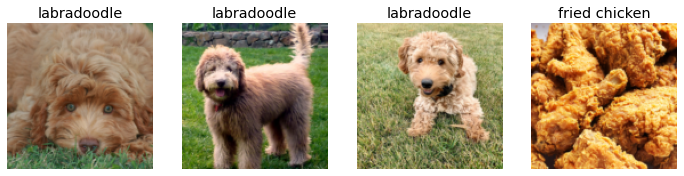

In [34]:
dls.valid.show_batch(max_n=4, nrows=1)

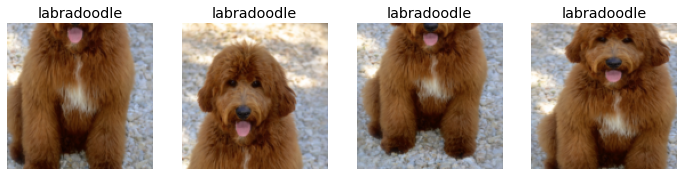

In [35]:
chicken_dogs = chicken_dogs.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = chicken_dogs.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

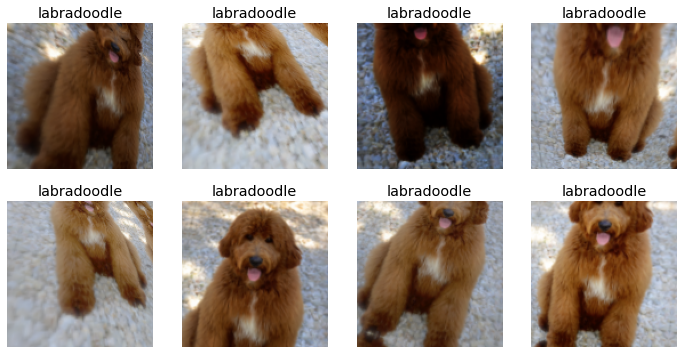

In [36]:
chicken_dogs = chicken_dogs.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = chicken_dogs.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [37]:
chicken_dogs = chicken_dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = chicken_dogs.dataloaders(path)

In [38]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.008628,0.039144,0.000000,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.064525,0.011172,0.000000,00:23
1,0.034087,0.001823,0.000000,00:23
2,0.024617,0.000657,0.000000,00:23
3,0.017962,0.000467,0.000000,00:23


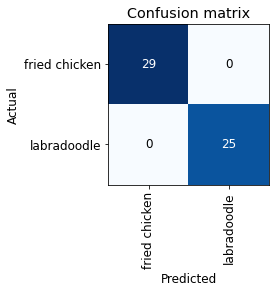

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

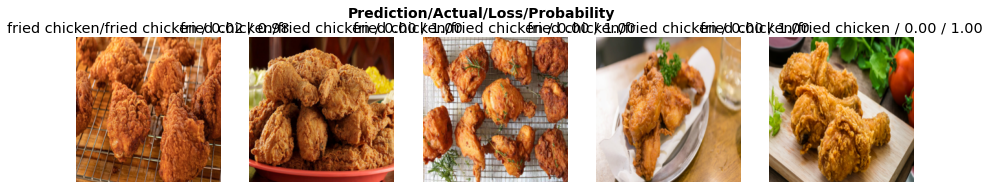

In [40]:
interp.plot_top_losses(5, nrows=1)

In [42]:
learn.export(fname='chicken_dog.pkl')

In [44]:
learn_inf = load_learner('chicken_dog.pkl')

In [46]:
from fastai.vision.widgets import *

In [47]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [50]:
img = PILImage.create(btn_upload.data[-1])

In [51]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [52]:
pred,pred_idx,probs = learn_inf.predict(img)

In [53]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: labradoodle; Probability: 0.9999')

In [54]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [55]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [56]:
btn_upload = widgets.FileUpload()

In [57]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])